# Using the _Herschel_-SPIRE Point Source Catalogue: demo \# 3

This simple notebook demonstrates a simple use of the SPIRE Point Source Catalogue (SPSC). The user provides source `SPSC_ID` (like this for example `HSPSC250B_J0109.73+3537.2`) and the script will loop over all OBSIDs where potentially the source may be and download the three SPIRE level-2 images for each band 250, 350 and 500 µm (mnemonic names `PSW`, `PMW` and `PLW` respectively) and will overlay the objects from the catalogue and optionally the sources from the initial source table, zoomed in with a user provided box (default in notebook 2x2 arcmin box).

**Required python packages:** `python 3.6` or above and in addition to the standard `numpy`, `matplotlib` you need `astropy`, and [`spherical_geometry`](https://github.com/spacetelescope/spherical_geometry) (can be installed with `pip`).

In [96]:
import os
import sys

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
plt.style.use('bmh')

%matplotlib inline

from astropy.io import fits
from astropy.table import Table
from astropy.wcs import WCS
from astropy.visualization import PercentileInterval, ImageNormalize
from astropy.nddata import Cutout2D

from astropy import units as u
from astropy.coordinates import SkyCoord

sys.path.append(os.getcwd())

from getSpirePhotMaps import getSpirePhotMaps
from whereis import whereis
from checkCoverage import check_coverage


## Some utility functions which will be needed

1. `getSpirePhotMaps()`: will download level-2 SPIRE maps from the [_Herschel_ Science Archive](http://archives.esac.esa.int/hsa/whsa/)
2. `whereis()`: will identify a list of OBSIDs where a point may lie within the 4-corners of the image footprint. Needs a `astropy.table.Table` object with columns "obsid,ra1,dec1,ra2,dec2,ra3,dec3,ra4,dec4".
3. `check_coverage`: will calculate the average coverage in a 3x3 box centred on the source. 

Both `whereis()` and `check_coverage` are used to identify an OBSID which contains the input (ra,dec) coordinates and has non-zero coverage.


## The main body of the notebook

In [97]:
spire_bands = ["PSW","PMW","PLW"]
#
# find the coordinates of the source, will need the full catalog
#
xid = 'HSPSC250B_J0109.73+3537.2'
coor = xid.split("_J")[1]
hh = coor[0:2] + "h" + coor[2:7] + "m" 
dd = coor[7:10] + "d" + coor[10:14] + "m"
source = SkyCoord(hh, dd)
ra_c = source.ra.value
dec_c = source.dec.value
#source = SkyCoord(ra=ra_c * u.deg, dec=dec_c * u.deg, frame='icrs') 
#
# next we load the footprints and identify OBSIDs where potentially the source may be in
#
footprints = Table.read('/Volumes/WORK/Works/herspire/SPIRE_PSC_v3/fourcorners_db.csv')
#
obsid_list = whereis(ra_c,dec_c,footprints)
nobs = len(obsid_list)
print (f"The point (RA, Dec)=({ra_c}, {dec_c}) deg is _potentially_ in {nobs} observations.")
#

/Users/ivaltcha/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/core/numeric.py:553: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)
/Users/ivaltcha/miniconda3/envs/py37/lib/python3.7/site-packages/spherical_geometry/polygon.py:590: RuntimeWarning: invalid value encountered in triple_product
  orient = great_circle_arc.triple_product(A-B, C-B, B)
/Users/ivaltcha/miniconda3/envs/py37/lib/python3.7/site-packages/spherical_geometry/polygon.py:133: RuntimeWarning: invalid value encountered in triple_product
  orient = great_circle_arc.triple_product(A-B, C-B, B)


The point (RA, Dec)=(17.4325, 35.62) deg is _potentially_ in 11 observations.


In [98]:
#
# set the Tmp where the archive .tar file will be stored
#
myTmp = os.path.join(os.path.expanduser('~'),"Tmp","HerschelData")
#
# download the maps, hmaps will be a dictionary of FITS HDUs with keys "PSW", "PMW" and "PLW"
#
# now loop over the obsid_list and once we found a map where the coverage is greater than 0 then we stop
#
for xobsid in obsid_list:
    hmaps = getSpirePhotMaps(xobsid,tmpDir=myTmp)
    covc = check_coverage(ra_c,dec_c,hmaps['PSW'])
    if (covc > 0.0):
        obsid = xobsid
        break
#    
target = hmaps['PSW'][0].header['OBJECT']

Found an already existing tar file for OBSID 1342212366. Will use it


In [99]:
#
# now read the catalogue and sources
#
cats_dir = '/Volumes/WORK/Works/herspire/SPIRE_PSC_v3/cats'
cat = {}
src = {}
for band in spire_bands:
    cat[band] = Table.read(f'{cats_dir}/{obsid}_{band}_catalog_sources.csv')
    src[band] = Table.read(f'{cats_dir}/{obsid}_{band}_sources.csv')
#

  gid             spscid          arrayname   flux  fluxerr
------- ------------------------- --------- ------- -------
2604564 HSPSC250B_J0109.73+3537.2       PSW 460.415  2.0074
2604544 HSPSC250B_J0109.68+3537.0       PSW 27.6253 1.89993
2604531 HSPSC250B_J0109.71+3536.6       PSW 23.5085 1.94313
3417776 HSPSC250B_J0109.69+3537.9       PSW 20.1648 2.36784
  gid             spscid          arrayname   flux  fluxerr
------- ------------------------- --------- ------- -------
2604557 HSPSC350B_J0109.73+3537.2       PMW  225.71 3.36454
2604462 HSPSC350B_J0109.69+3537.9       PMW 24.9327 2.21305
  gid             spscid          arrayname   flux  fluxerr
------- ------------------------- --------- ------- -------
2604542 HSPSC500B_J0109.73+3537.1       PLW 115.858   2.395


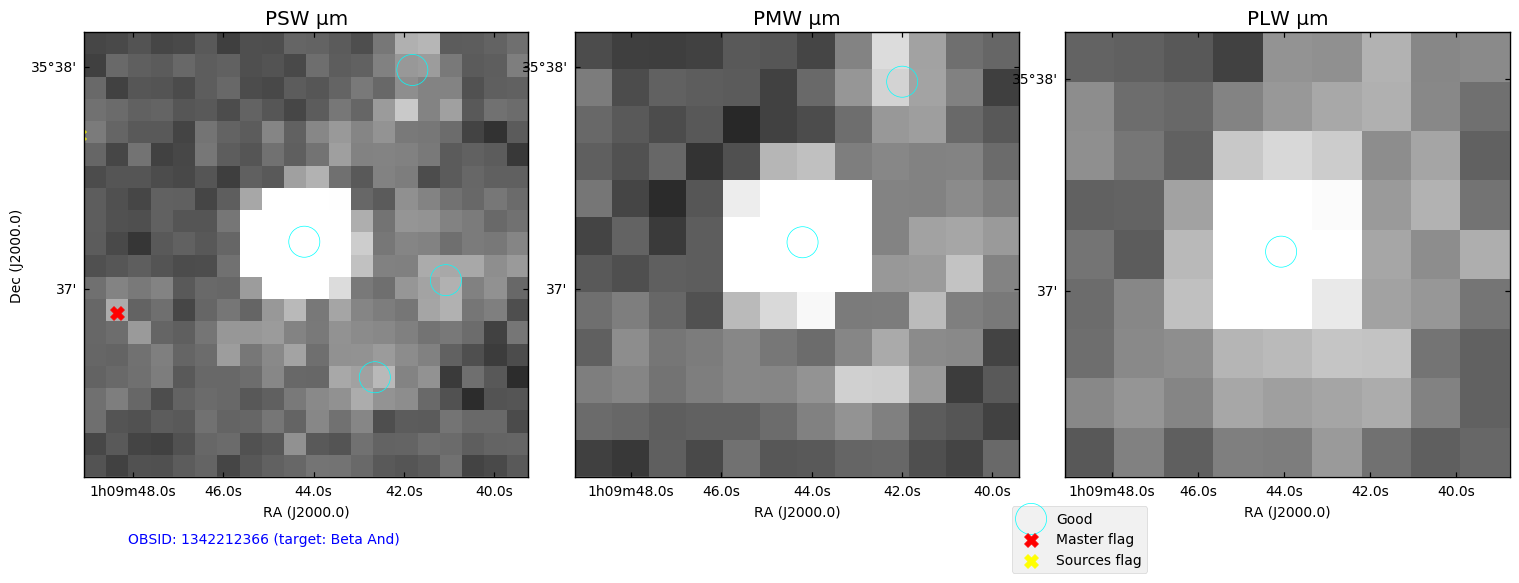

In [100]:
#
# plot the maps and the sources
#
# user selected zoom box (in arcmin)
zx = 2.0
zoomSize = u.Quantity((zx,zx), u.arcmin)
#
fig = plt.figure(figsize=(15,5),dpi=100)
pp = 98.0 # 
for k,band in enumerate(spire_bands):
    ximage = hmaps[band]['image']
    wcs = WCS(hmaps[band]['image'].header)
    norm = ImageNormalize(ximage.data[~np.isnan(ximage.data)], interval=PercentileInterval(pp))
    #
    cutout = Cutout2D(ximage.data, source, zoomSize, wcs=wcs)
    wcs_cut = cutout.wcs
    ax = fig.add_subplot(1,3,k+1,projection=wcs_cut)
    ax.set_title(f'{band} µm')
    lon = ax.coords['ra']
    lon.set_axislabel('RA (J2000.0)')
    lon.set_major_formatter('hh:mm:ss.s')
    lat = ax.coords['dec']
    if (k == 0):
        lat.set_axislabel('Dec (J2000.0)')
    else:
        lat.set_axislabel('')
    lat.set_major_formatter('dd:mm')    
    ax.imshow(cutout.data,norm=norm,cmap=plt.cm.gray,origin='lower',interpolation='nearest')
    ax.set_autoscale_on(False)
    #
    # now plot the catalog and sources
    #
    rax = cat[band]['ra']
    decx = cat[band]['dec']
    #igood = np.where(cat[band]['master'] == 't')[0]
    catalog = SkyCoord(ra=rax*u.degree, dec=decx*u.degree, frame='icrs')
    m1 = cat[band]['master'] == 't'
    d2d = source.separation(catalog)  
    m2 = d2d < zx*u.arcmin/2.0
    igood = np.where(m1*m2)[0]
    #
    cxx = cat[band][igood]
    # sort on flux and print
    ixx = cxx.argsort('flux')
    cxx = cxx[np.flip(ixx)]
    print (cxx["gid","spscid","arrayname","flux","fluxerr"])
    #
    # the flagged sources
    #
    ibad = np.where(cat[band]['master'] == 'f')[0]
    #
    # the sources
    #
    raz = src[band]['ra']
    decz = src[band]['dec']
    iz = np.where(src[band]['master'] == 'f')[0]
    #
    ax.scatter(rax[igood], decx[igood], transform=ax.get_transform('fk5'), 
               s=500,edgecolor='red', facecolor='none', label='Good')
    ax.scatter(rax[ibad], decx[ibad], transform=ax.get_transform('world'), 
               s=100,marker='X', c='magenta', label='Master flag')
    ax.scatter(raz[iz], decz[iz], transform=ax.get_transform('world'), 
               s=100,marker='X', c='yellow', label='Sources flag')
    if (k == 0):
        ax.text(0.1,-0.15,f'OBSID: {obsid} (target: {target})',transform=ax.transAxes,color='b')
plt.tight_layout(pad=2)
plt.legend(bbox_to_anchor=(0.2, -0.05))
lgnd.legendHandles[0]._sizes = [50];